# Exploring time series in python

**Date started**: 21st June 2022

**Guide**: https://rishi-a.github.io/2020/05/25/granger-causality.html

**Factors to consider altering/adding**: 
* Normalisation
* Transformation (log) - **added to this script**
* Checking all VAR fit stats
* Lag

In [1]:
# Inputs
shift_lag = -2*7
forecast_steps = 30
log_prevalence = True
granger_lag=14

print('INPUTS USED:\n')
print(f'- Lag used is {shift_lag} days\n')
print(f'- Forecasting ahead {forecast_steps} days\n')
if (log_prevalence==True):
    print("- Logged prevalence data is used")
else:
    print("- Non-logged prevalence data is used")

INPUTS USED:

- Lag used is -14 days

- Forecasting ahead 30 days

- Logged prevalence data is used


In [2]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import timedelta
import statsmodels.tsa.stattools as smt
from statsmodels.tsa.api import VAR
from dateutil.relativedelta import relativedelta
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import JohansenTestResult
import statsmodels.tsa.stattools as ts 
from statsmodels.tsa.stattools import grangercausalitytests
import sklearn
from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.stats.stattools import durbin_watson

/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Use this to install any packages required in general:

# import subprocess
# import sys

# def install(package):
#    subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    
# install("johansen")

In [4]:
# Setting plot sizes
plt.rcParams["figure.figsize"] = (12,9)

In [5]:
# Useful dates

lockdown_1_start = dt.datetime.strptime("2020-03-26","%Y-%m-%d")
lockdown_1_end = dt.datetime.strptime("2020-06-15","%Y-%m-%d")

lockdown_2_start = dt.datetime.strptime("2020-11-05","%Y-%m-%d")
lockdown_2_end = dt.datetime.strptime("2020-12-02","%Y-%m-%d")

lockdown_3_start = dt.datetime.strptime("2021-01-06","%Y-%m-%d")
lockdown_3_end = dt.datetime.strptime("2021-04-21","%Y-%m-%d")

REACT_start = dt.datetime.strptime("2020-05-01","%Y-%m-%d")

start_date = REACT_start
end_date = lockdown_2_start-relativedelta(months=1)

print(f'Start date is: {start_date}, i.e. start of REACT data')
print(f'End date is: {end_date}, i.e. one month before the start of lockdown 2')

Start date is: 2020-05-01 00:00:00, i.e. start of REACT data
End date is: 2020-10-05 00:00:00, i.e. one month before the start of lockdown 2


## Time Series

Exploring Granger Causality using tutorial - https://rishi-a.github.io/2020/05/25/granger-causality.html

In [6]:
# Loading data

mob_long = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_long.csv", index_col='date',parse_dates=['date'])
mob_wide = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Mapping/Outputs/google_regional_wide.csv", index_col='date',parse_dates=['date'])
prev = pd.read_csv("/Users/elliebloom/Desktop/Masters/Project/Analysis/Time_series_analysis/Ouputs/Tibbles/prev_smooth_tibble.csv", index_col='d_comb',parse_dates=['d_comb'])

mob_long.index = pd.to_datetime(mob_long.index)
mob_wide.index = pd.to_datetime(mob_wide.index)
mob_wide = mob_wide.sort_index()
prev = prev.sort_index()

# Using log prevalence if specified
if(log_prevalence==True):
    prev['p']=np.log(prev['p'])

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


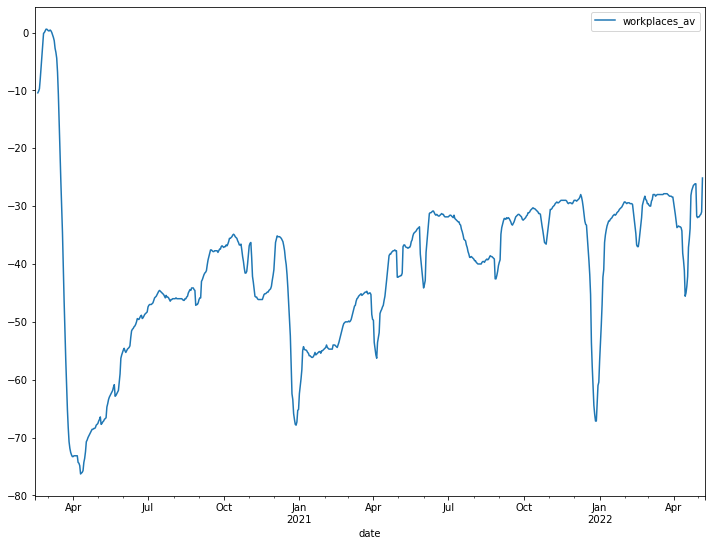

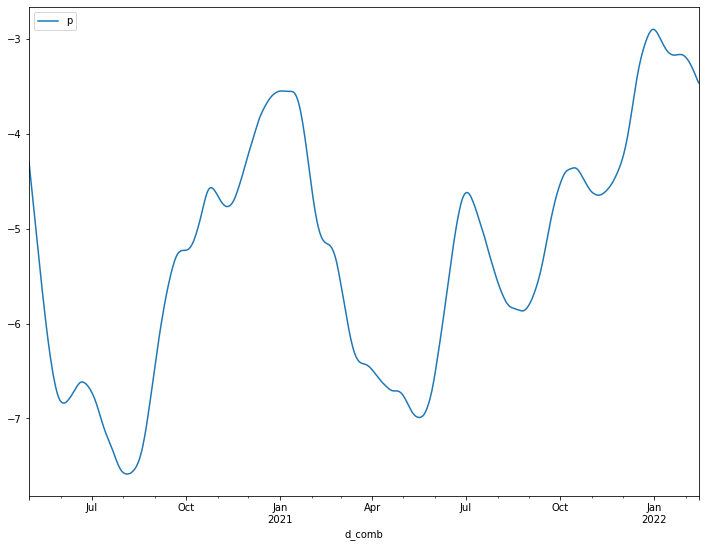

In [7]:
# Focusing on London
mob_london = mob_wide[mob_wide['region']=="LONDON"]
prev_london = prev[prev['region']=="LONDON"]

# Only including columns of interest
mob_london = mob_london[['workplaces_av']]
prev_london = prev_london[['p']]

# Plots over whole period of data
print(mob_london.plot())
print(prev_london.plot())

# Note not yet restricted the dates yet at this point

In [8]:
# Shifting by specified lag - as calculated by CCF of log(prev) vs mobility

print(f'Lag used is {shift_lag} days')
mob_london['workplaces_av']=mob_london['workplaces_av'].shift(shift_lag)

Lag used is -14 days


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


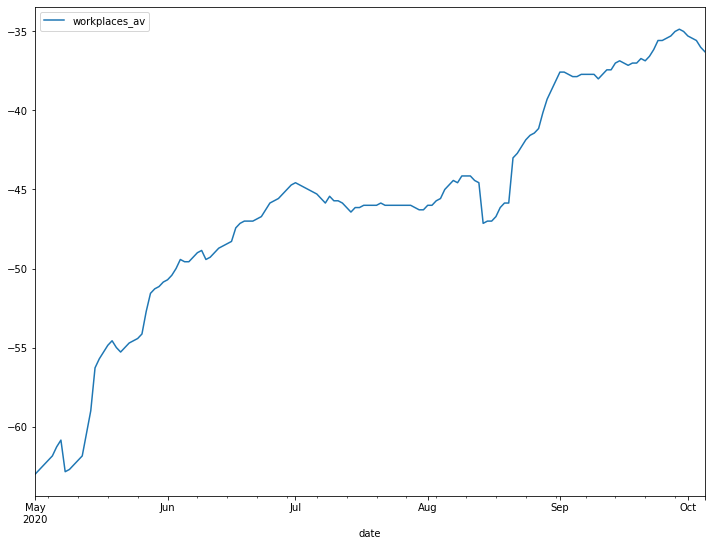

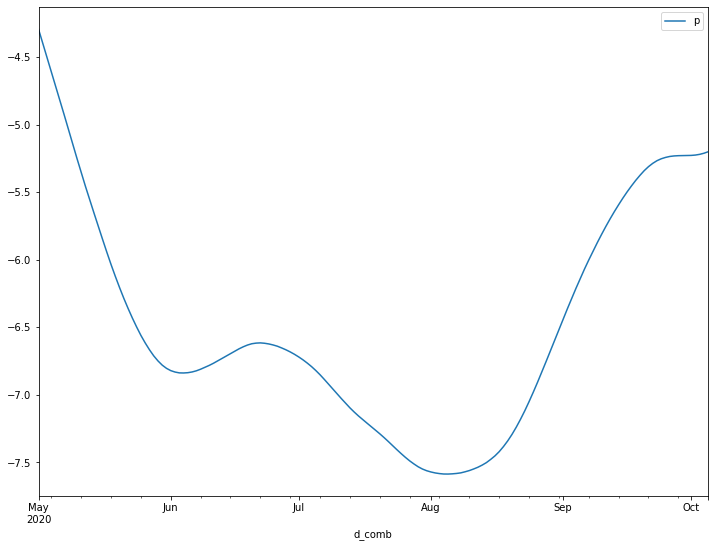

In [9]:
# Focussing on specified interval
mob_london = mob_london.loc[start_date:end_date]
prev_london = prev_london.loc[start_date:end_date]
print(mob_london.plot())
print(prev_london.plot())

# mob_london and prev_london are now restricted by date

In [10]:
# Merging into a combined London dataframe
london = pd.merge(mob_london, prev_london, how='inner', left_index=True, right_index=True)
# london dataframe starts at the start_date and ends at the end_date

In [11]:
# NO LONGER NEEDED

# Removing the columns that aren't needed
#london = london[['workplaces_av','p']]
#london.tail()

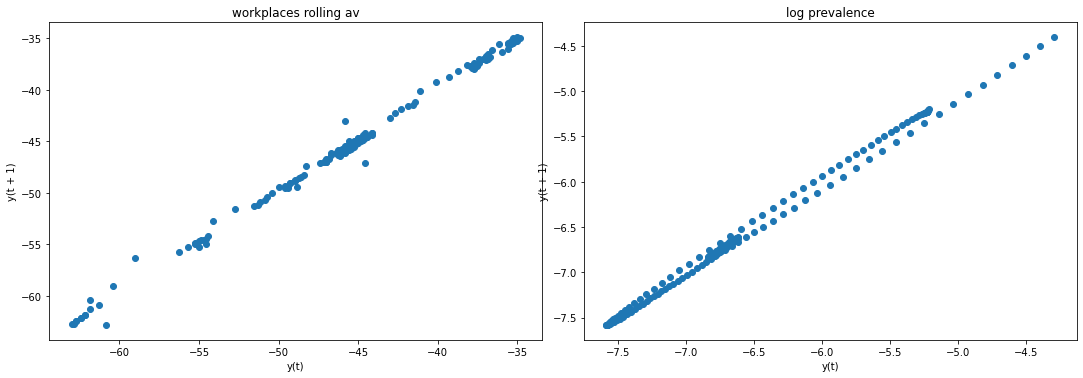

In [12]:
# Plotting yt vs yt+1 to investigate autocorrelation
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence');

In [13]:
# Making a copy of the data prior to differencing
raw_london = london.copy(deep=True)

# raw_london is undifferenced and dates are restricted between start_date and end_date

In [14]:
# Differencing - differencing required for both rolling av mobility and log prevalence

london['workplaces_av'] = london['workplaces_av'] - london['workplaces_av'].shift(1)
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()

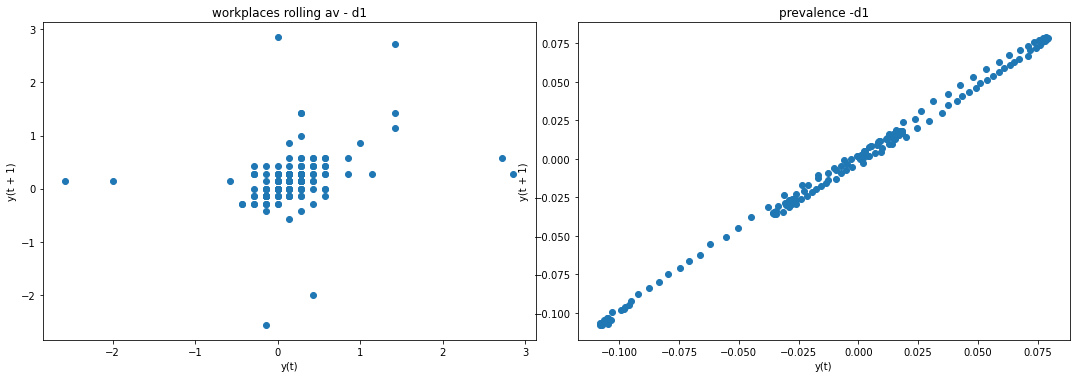

In [15]:
# Plots after differencing once

f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('prevalence -d1');

In [16]:
# There is still clear autocorrelation for prevalence so difference this once again
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()

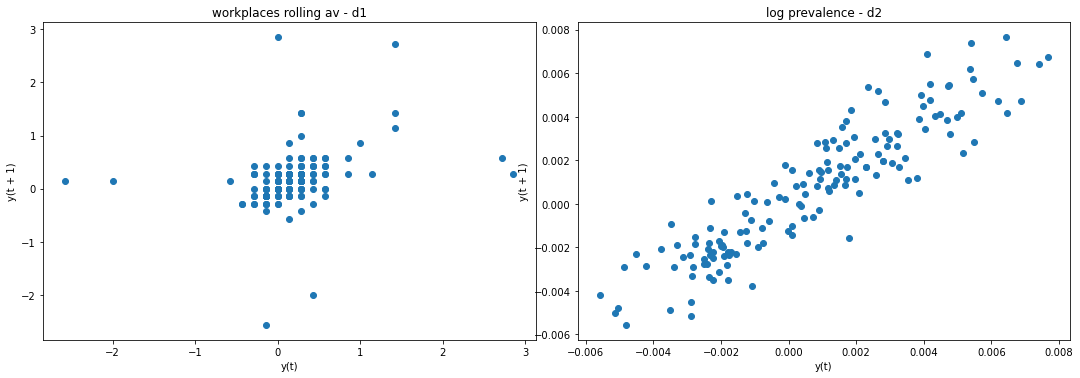

In [17]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence - d2');

In [18]:
# Differencing prevalence again

# There is still clear autocorrelation for prevalence so shift this once again
london['p'] = london['p'] - london['p'].shift(1)
london = london.dropna()
london.head()

,workplaces_av,p
date,,
2020-05-04,0.285714,0.001899
2020-05-05,0.285714,-0.003340
2020-05-06,0.571429,-0.000742
2020-05-07,0.428571,0.002404
2020-05-08,-2.000000,-0.001128


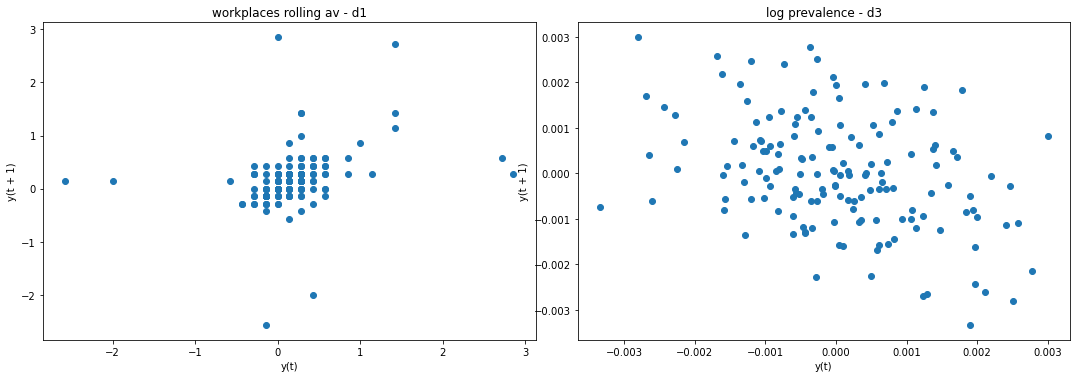

In [19]:
# Plotting again
   
f2, (ax4, ax5) = plt.subplots(1, 2, figsize=(15, 5))
f2.tight_layout()

lag_plot(london['workplaces_av'], ax=ax4)
ax4.set_title('workplaces rolling av - d1');

lag_plot(london['p'], ax=ax5)
ax5.set_title('log prevalence - d3');

Looks ok now - so mobility is differenced once, prevalence 3 times. Next to statistically test that these are stationary

In [20]:
## ADF Null hypothesis: there is a unit root, meaning series is non-stationary

# Checking stationarity of differenced data with restricted date between start_date and end_date

X1 = np.array(london['workplaces_av'])
X1 = X1[~np.isnan(X1)]

ADF_mob = adfuller(X1)
print('ADF Statistic: %f' % ADF_mob[0])
print('p-value: %f' % ADF_mob[1])
if (ADF_mob[1]<0.05): print('Mobility is stationary as p<0.05')
if (ADF_mob[1]>0.05): print('Mobility is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_mob[4].items():
    print('\t%s: %.3f' % (key, value))
    
    
ADF_mob_t = ADF_mob[0]
ADF_mob_p = ADF_mob[1]    
    
X2 = np.array(london['p'])
X2 = X2[~np.isnan(X2)]

ADF_prev = adfuller(X2)
print('ADF Statistic: %f' % ADF_prev[0])
print('p-value: %f' % ADF_prev[1])
if (ADF_prev[1]<0.05): print('Prevalence is stationary as p<0.05')
if (ADF_prev[1]>0.05): print('Prevalence is non-stationary as p>0.05')
print('Critical Values:')
for key, value in ADF_prev[4].items():
    print('\t%s: %.3f' % (key, value))
    
ADF_prev_t = ADF_prev[0]
ADF_prev_p = ADF_prev[1] 

ADF Statistic: -3.992209
p-value: 0.001452
Mobility is stationary as p<0.05
Critical Values:
	1%: -3.476
	5%: -2.881
	10%: -2.577
ADF Statistic: -4.871892
p-value: 0.000040
Prevalence is stationary as p<0.05
Critical Values:
	1%: -3.475
	5%: -2.881
	10%: -2.577


In [21]:
## KPSS Null hypothesis: there is a no unit root, meaning series is stationary

from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

KPSS_mob_stat = kpss(X1)[0]
KPSS_mob_p = kpss(X1)[1]

KPSS_prev_stat = kpss(X2)[0]
KPSS_prev_p = kpss(X2)[1]
    
kpss_test(X1)
kpss_test(X2)

# now stationary

KPSS Statistic: 0.2492755533984144
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary
KPSS Statistic: 0.06932911006319453
p-value: 0.1
num lags: 14
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater 

Overall result to far -  both stationary:  
* Mobility - d=1
* Prevalence - logged, d=3

In [22]:
# split data into train and test. We will need this later for VAR analysis

# Considering if seeding in this way is the most appropriate - https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
np.random.seed(5)
msk = np.random.rand(len(london)) < 0.8
train = london[msk]
test = london[~msk]

# Note train and test are using the differenced data, restricted from start_date to end_date

Result: lag plot is confirmatory with ADF test and KPSS. Uses moving average and 3 differences

Next: setting up VAR model

**Step 2**: Let the maximum order of integration for the group of time-series be d. So, if there are two time-series and one is found to be I(1) and the other is I(2), then d = 2. If one is I(0) and the other is I(1), then m = 1, etc.

**Result**: Saw above that in this case d=1

**Step 3**: Set up a VAR model in the levels of the data, regardless of the orders of integration of the various time-series. Most importantly, **you must not difference the data, no matter what you found at Step 1**.

**Step 4**: Determine the appropriate maximum lag length for the variables in the VAR, say p, using the usual methods. Specifically, base the choice of p on the usual information criteria, such as AIC, SIC.


**Note**: try running like this first, then incorporate info on the lag later


In [23]:
# Trying cross-validation for model selection instead

In [24]:
raw_london.head()

,workplaces_av,p
date,,
2020-05-01,-63.000000,-4.295143
2020-05-02,-62.714286,-4.400168
2020-05-03,-62.428571,-4.505304
2020-05-04,-62.142857,-4.608653
2020-05-05,-61.857143,-4.713554


In [25]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html
from sklearn.model_selection import TimeSeriesSplit

In [26]:
# https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/

class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [27]:
raw_london = raw_london.dropna()

res_dict_cv = {'Lag': [],'MAE': [], 'MSE':[], 'MAPE':[]}

tscv = BlockingTimeSeriesSplit(n_splits=5)

# Lengths are a bit small
# Would be good to extend the forecast to beyond 7 and extend the test size

for train_index, test_index in tscv.split(raw_london):
    for i in range(1,13):
        print(f"Train:{train_index}")
        print(f"Test:{test_index}")
        train = raw_london.iloc[train_index]
        test = raw_london.iloc[test_index]
        model = VAR(train)
        result = model.fit(i)
        lagged_values = train.values[-i:]
        pred = result.forecast(y=lagged_values, steps=test.shape[0]) 
        pred_prev = pred[:,1]
        actual_prev = test.values[:,1]
        res_dict_cv['Lag'].append(i)
        res_dict_cv['MAE'].append(metrics.mean_absolute_error(actual_prev, pred_prev))
        res_dict_cv['MSE'].append(metrics.mean_squared_error(actual_prev, pred_prev))
        res_dict_cv['MAPE'].append(metrics.mean_squared_error(actual_prev, pred_prev))

res_dict_cv
        
model_result_cv = pd.DataFrame(res_dict_cv)

Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Test:[24 25 26 27 28 29 30]
Train:[ 0  1  2  3  4  5  6 

/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/elliebloom/opt/anaconda3/lib/python3.8/site-p

In [28]:
model_result_cv.tail()

,Lag,MAE,MSE,MAPE
55,8,0.115768,0.026913,0.026913
56,9,0.100184,0.017567,0.017567
57,10,0.025123,0.001341,0.001341
58,11,0.960716,2.466111,2.466111
59,12,0.124748,0.019135,0.019135


In [29]:
res_dict = {'Lag': [],'MAE_mean': [], 'MAE_sd':[], 'MSE_mean':[], 'MSE_sd':[], 'MAPE_mean':[],'MAPE_sd':[]}

for i in range(1,13):
    result_lag = model_result_cv[model_result_cv['Lag']==i]
    res_dict['Lag'].append(i)
    res_dict['MAE_mean'].append(np.mean(result_lag['MAE']))
    res_dict['MAE_sd'].append(np.std(result_lag['MAE']))
    res_dict['MSE_mean'].append(np.mean(result_lag['MSE']))
    res_dict['MSE_sd'].append(np.std(result_lag['MSE']))
    res_dict['MAPE_mean'].append(np.mean(result_lag['MAPE']))
    res_dict['MAPE_sd'].append(np.std(result_lag['MAPE']))
       

In [30]:
model_result = pd.DataFrame(res_dict)
model_result

,Lag,MAE_mean,MAE_sd,MSE_mean,MSE_sd,MAPE_mean,MAPE_sd
0,1,0.079220,0.057825,0.014661,0.017089,0.014661,0.017089
1,2,0.021532,0.016382,0.001289,0.001647,0.001289,0.001647
2,3,0.025852,0.018180,0.001766,0.002570,0.001766,0.002570
3,4,0.021765,0.019856,0.001549,0.002552,0.001549,0.002552
4,5,0.026897,0.019205,0.001967,0.002632,0.001967,0.002632
5,6,0.034332,0.036210,0.004351,0.007675,0.004351,0.007675
6,7,0.033505,0.039826,0.004710,0.008806,0.004710,0.008806
7,8,0.065574,0.044802,0.011756,0.010528,0.011756,0.010528
8,9,0.043599,0.032745,0.005737,0.006492,0.005737,0.006492
9,10,0.046484,0.041109,0.012791,0.022270,0.012791,0.022270


In [31]:
print(f"The lag that minimises the MAE is: {np.argmin(model_result['MAE_mean'])+1}")
print(f"The lag that minimises the MSE is: {np.argmin(model_result['MSE_mean'])+1}")
print(f"The lag that minimises the MAPE is: {np.argmin(model_result['MAPE_mean'])+1}")

lag_order = np.argmin(model_result['MAE_mean'])+1
lag_order_MSE = np.argmin(model_result['MSE_mean'])+1
lag_order_MAPE = np.argmin(model_result['MAPE_mean'])+1

The lag that minimises the MAE is: 2
The lag that minimises the MSE is: 2
The lag that minimises the MAPE is: 2


In [32]:
model = VAR(np.asarray(london))
model_fitted = model.fit(lag_order)
# Note this is now using the differened data within the restricted dates

In [33]:
# obtain the lag P for VAR

# raw_london = raw_london.dropna()
# model = VAR(np.array(raw_london)) #recall that rawData is w/o difference operation
# raw_london.tail()

# raw_london is undifferenced and dates are restricted between start_date and end_date

In [34]:
# res_dict = {'Lag': [],'AIC': [], 'BIC':[], 'FPE':[], 'HQIC': []}
# for i in range(1, 13):
#     result = model.fit(i)
#     res_dict['Lag'].append(i)
#     res_dict['AIC'].append(result.aic)
#     res_dict['BIC'].append(result.bic)
#     res_dict['FPE'].append(result.fpe)
#     res_dict['HQIC'].append(result.hqic)
    
# model_result = pd.DataFrame(res_dict)
# model_result

In [35]:
# print(f"The lag that minimises the AIC is: {np.argmin(model_result['AIC'])+1}")
# print(f"The lag that minimises the BIC is: {np.argmin(model_result['BIC'])+1}")
# print(f"The lag that minimises the FPE is: {np.argmin(model_result['FPE'])+1}")
# print(f"The lag that minimises the HQIC is: {np.argmin(model_result['HQIC'])+1}")

**Result**: The lag order p=8 on the basis of AIC  
**Step 5**: Make sure that the VAR is well-specified. For example, ensure that there is no serial correlation in the residuals. If need be, increase p until any autocorrelation issues are resolved.

In [36]:
# # Using AIC as the criteria
# lag_order = np.argmin(model_result['AIC'])+1
# lag_order_BIC = np.argmin(model_result['BIC'])+1
# lag_order_FPE = np.argmin(model_result['FPE'])+1
# lag_order_HQIC = np.argmin(model_result['HQIC'])+1
# print(f"Lag used based on minising the AIC is:{lag_order}")

# model = VAR(np.asarray(train))
# model_fitted = model.fit(lag_order) 

# # Note train and test are using the differenced data, restricted from start_date to end_date

In [37]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.

out = durbin_watson(model_fitted.resid)

for col, val in zip(london.columns, out):
    print(col, ':', round(val, 2))

resid_corr_mob = out[0]
resid_corr_prev = out [1]

workplaces_av : 2.01
p : 2.04


**Result**: There is no significant correlation between in the residuals

**Step 6**: If two or more of the time-series have the same order of integration, at Step 1, then test to see if they are cointegrated, preferably using Johansen’s methodology (based on your VAR) for a reliable result.  

**Johansen's test**:   
H0: There are no cointegrating equations 

In [38]:
# Function from here : http://web.pdx.edu/~crkl/ceR/Python/example14_3.py

"""
    Johansen cointegration test of the cointegration rank of a VECM

    Parameters
    ----------
    endog : array_like (nobs_tot x neqs)
        Data to test
    det_order : int
        * -1 - no deterministic terms - model1
        * 0 - constant term - model3
        * 1 - linear trend
    k_ar_diff : int, nonnegative
        Number of lagged differences in the model.
"""



def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"])
    print(output.T,'\n')
    print("Series 0 is mobility")
    print("Series 1 is prevalence\n")
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')
    
    if (res.lr2[0]>res.cvm[0][1]): 
        print('Mobility series cointegrates using eigenvalue method at 95% level')
    else:
        print('Mobility series does not cointegrate using eigenvalue method at 95% level')
        
    if (res.lr2[0]>res.cvt[0][1]): 
        print('Mobility series cointegrates using trace method at 95% level')
    else:
        print('Mobility series does not cointegrate using trace method at 95% level')  
        
    if (res.lr1[1]>res.cvm[1][1]): 
        print('Prevalence series cointegrates using eigenvalue method at 95% level')
    else:
        print('Prevalence series does not cointegrate using eigenvalue method at 95% level')
    
    if (res.lr2[1]>res.cvt[1][1]): 
        print('Prevalence series cointegrates using trace method at 95% level')
    else:
        print('Prevalence series does not cointegrate using trace method at 95% level')  

        
result = coint_johansen(np.asarray(raw_london),0,1)
joh_output(result)


johansen_eigenvalue_mob =result.lr2[0]
johansen_trace_mob= result.lr1[0]
johansen_eigenvalue_prev = result.lr2[1]
johansen_trace_prev=result.lr1[1]
johansen_eignvalue_95_mob = result.cvm[0][1]
johansen_eignvalue_95_prev =  result.cvm[1][1]
johansen_trace_95_mob = result.cvt[0][1]
johansen_trace_95_prev = result.cvt[1][1]



# raw_london is undifferenced and dates are restricted between start_date and end_date

   max_eig_stat  trace_stat
0     55.719028   65.233181
1      9.514154    9.514154 

Series 0 is mobility
Series 1 is prevalence

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 

Mobility series cointegrates using eigenvalue method at 95% level
Mobility series cointegrates using trace method at 95% level
Prevalence series cointegrates using eigenvalue method at 95% level
Prevalence series cointegrates using trace method at 95% level


**Result**: Greater than all critical values, thus p<0.05 - Thus rejecting the null hypothesis. Thus they are cointegrated.

In [39]:
# Trying the other test done in the tutorial
# This uses the augmented Engle-Granger two-step cointegration test. Constant or trend is included in 1st stage regression, i.e. in cointegrating equation.

result=ts.coint(london['workplaces_av'], london['p'], return_results=True) # note using the differenced data
print(result)

if (result[1]<0.05):
    print("The two time series are cointegrated (p<0.05)")
else:
    print("The two time series are NOT cointegrated (p>0.05)")

# Note the results includes: t stat, p value, [1% critical value, 5% critical value, 10% critical value]

# Why use the differenced data here and not elsewhere? Note this test is not significant when using the raw non-differentiated data - NEED TO FIGURE THIS OUT!!

(-3.993960482541849, 0.007324973903728224, array([-3.96896992, -3.37609367, -3.07210495]))
The two time series are cointegrated (p<0.05)


**Result** : The p-values < 0.05. Thus now rejecting the null hypothesis. Thus they are cointegrated using this alternative test too.

**Step 7**: No matter what you conclude about cointegration at Step 6, this is not going to affect what follows. It just provides a possible cross-check on the validity of your results at the very end of the analysis.  
**Step 8**: Now take the preferred VAR model and add in m additional lags of each of the variables into each of the equations.  

In [40]:
# Model previously fitted like this - what does it mean add it an additional m lags?
#model = VAR(np.asarray(train))
#model_fitted = model.fit(lag_order)

# WHAT DOES THIS EXTRA LAGS BIT MEAN??


**Step 9 and Step 10**: Test for Granger non-causality. It’s essential that you don’t include the coefficients for the ‘extra’ m lags when you perform the tests. They are there just to fix up the asymptotics.

**Granger causality test using variable lag from VAR**

^ I'm not sure I've done step 8 right, and not sure what it means by the 'extra' lags above? Should add them in later?

In [41]:

maxlag=lag_order #becuase we got this value before. We are not suppose to add 1 to it

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_variable = grangers_causation_matrix(london, variables = train.columns)  

In [42]:
print(granger_variable)
print("\n")

if(granger_variable.iloc[0,1]<0.05):
    print(f"Prevalence granger causes mobility (using VAR lag of {lag_order}) as p<0.05 (p={granger_variable.iloc[0,1]})\n")
else:
    print(f"Prevalence does NOT granger causes mobility (using VAR lag of {lag_order}) as p>0.05 (p={granger_variable.iloc[0,1]})\n")
    
if(granger_variable.iloc[1,0]<0.05):
    print(f"Mobility granger causes prevalence (using VAR lag of {lag_order}) as p<0.05 (p={granger_variable.iloc[1,0]})")
else:
    print(f"Mobility does NOT granger causes prevalence (using VAR lag of {lag_order}) as p>0.05 (p={granger_variable.iloc[1,0]})")

    
granger_p_mob_prev_variable = granger_variable.iloc[1,0]
granger_p_prev_mob_variable = granger_variable.iloc[0,1]

                 workplaces_av_x    p_x
workplaces_av_y           1.0000  0.032
p_y                       0.0032  1.000


Prevalence granger causes mobility (using VAR lag of 2) as p<0.05 (p=0.032)

Mobility granger causes prevalence (using VAR lag of 2) as p<0.05 (p=0.0032)


**Granger causality test with fixed lag of 14**

In [43]:

maxlag=granger_lag #becuase we got this value before. We are not suppose to add 1 to it

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

granger_fixed = grangers_causation_matrix(london, variables = train.columns)  

In [44]:
print(granger_fixed)
print("\n")

if(granger_fixed.iloc[0,1]<0.05):
    print(f"Prevalence granger causes mobility (using fixed lag of 14) as p<0.05 (p={granger_fixed.iloc[0,1]})\n")
else:
    print(f"Prevalence does NOT granger causes mobility (using fixed lag of 14) as p>0.05 (p={granger_fixed.iloc[0,1]})\n")
    
if(granger_fixed.iloc[1,0]<0.05):
    print(f"Mobility granger causes prevalence (using fixed lag of 14) as p<0.05 (p={granger_fixed.iloc[1,0]})")
else:
    print(f"Mobility does NOT granger causes prevalence (using fixed lag of 14) as p>0.05 (p={granger_fixed.iloc[1,0]})")

    
granger_p_mob_prev_fixed = granger_fixed.iloc[1,0]
granger_p_prev_mob_fixed = granger_fixed.iloc[0,1]

                 workplaces_av_x    p_x
workplaces_av_y           1.0000  0.032
p_y                       0.0032  1.000


Prevalence granger causes mobility (using fixed lag of 14) as p<0.05 (p=0.032)

Mobility granger causes prevalence (using fixed lag of 14) as p<0.05 (p=0.0032)


      
**Result**: If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). 

**Step 11**: Finally, look back at what you concluded in Step 6 about cointegration.  

If two or more time-series are cointegrated, then there must be Granger causality between them - either one-way or in both directions. However, the converse is not true.

So, if your data are cointegrated but you don't find any evidence of causality, you have a conflict in your results. (**This might occur if your sample size is too small to satisfy the asymptotics that the cointegration and causality tests rely on.**) If you have cointegration and find one-way causality, everything is fine. (You may still be wrong about there being no causality in the other direction.) If your data are not cointegrated, then you have no cross-check on your causality results.


**Now diverging from the tutorial, exploring forecasting**

In [45]:
# Exploring forecasting

# Firstly summary of the model
model_fitted.summary()
# y1  = mobility
# y2 = prevalence

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 28, Jun, 2022
Time:                     12:10:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.7379
Nobs:                     153.000    HQIC:                  -14.8555
Log likelihood:           718.407    FPE:                3.26143e-07
AIC:                     -14.9360    Det(Omega_mle):     3.05827e-07
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.103472         0.043789            2.363           0.018
L1.y1         0.271228         0.081826            3.315           0.001
L1.y2       -61.314926        36.251409           -1.691           0.091
L2.y1         0.101499

**Result**: None of the coefficients are significant for mobility (y1) for the equation for y2 (prevalence). However, nor are any of the prevalence ones either??

In [46]:
# Forecasting ahead
# https://www.analyticsvidhya.com/blog/2021/08/vector-autoregressive-model-in-python/

lagged_Values = london.values[-lag_order:] # london is the differenced data, restricted between start_date and end_date
pred = model_fitted.forecast(y=lagged_Values, steps=forecast_steps) 

In [47]:
# Tidying this up into a dataframe with dates
pred = pd.DataFrame(data=pred,columns=['workplaces_av_pred','p_pred'])
days = pd.date_range(np.max(raw_london.index)+relativedelta(days=1), np.max(raw_london.index) + timedelta(forecast_steps), freq='D')
pred['date']=days
pred = pred.set_index('date')
print(pred.head(10))
pred.tail(50)

# case see that the differences for both converge??


            workplaces_av_pred    p_pred
date                                    
2020-10-06           -0.018657  0.000277
2020-10-07            0.052392  0.000046
2020-10-08            0.112593  0.000085
2020-10-09            0.134077  0.000036
2020-10-10            0.148913  0.000041
2020-10-11            0.154914  0.000031
2020-10-12            0.158662  0.000031
2020-10-13            0.160297  0.000029
2020-10-14            0.161256  0.000028
2020-10-15            0.161696  0.000028


,workplaces_av_pred,p_pred
date,,
2020-10-06,-0.018657,0.000277
2020-10-07,0.052392,0.000046
2020-10-08,0.112593,0.000085
2020-10-09,0.134077,0.000036
2020-10-10,0.148913,0.000041
2020-10-11,0.154914,0.000031
2020-10-12,0.158662,0.000031
2020-10-13,0.160297,0.000029
2020-10-14,0.161256,0.000028


In [48]:
# Adding this onto the original dataframe and creating separate dataframes for mobility and prevalence
merged_data = pd.concat([london,pred])
data_prev = merged_data.drop(['workplaces_av_pred', 'workplaces_av'], axis=1)
data_mob = merged_data.drop(['p_pred', 'p'], axis=1)

# Reversing the differencing

### Mobility

In [49]:
london_data = mob_wide[mob_wide['region']=="LONDON"]
london_data = london_data[['workplaces_av']]
london_data.rename(columns = {'workplaces_av':'workplaces_av_undiff'}, inplace = True)

# london_data is undifferenced and unrestricted by date

In [50]:
london_forecast=pd.concat([london_data, data_mob], axis=1)
forecast_start_date = end_date+relativedelta(days=1)
forecast_end_date =  end_date+relativedelta(days=forecast_steps)
london_forecast = london_forecast.loc[start_date:forecast_end_date]

In [51]:
london_forecast['diff_cum_sum'] = london_forecast['workplaces_av_pred'].cumsum()
london_forecast['workplaces_av_pred_undiff']=np.nan
london_forecast['workplaces_av_pred_undiff'].loc[end_date] = london_forecast['workplaces_av_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    london_forecast['workplaces_av_pred_undiff'].loc[end_date+relativedelta(days=i)]=london_forecast['workplaces_av_pred_undiff'].loc[end_date]+london_forecast['diff_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
london_forecast.tail(31)   


,workplaces_av_undiff,workplaces_av,workplaces_av_pred,diff_cum_sum,workplaces_av_pred_undiff
date,,,,,
2020-10-05,-36.857143,-0.285714,NaN,NaN,-36.875800
2020-10-06,-36.571429,NaN,-0.018657,-0.018657,-36.842065
2020-10-07,-36.142857,NaN,0.052392,0.033735,-36.729471
2020-10-08,-35.571429,NaN,0.112593,0.146329,-36.595394
2020-10-09,-35.571429,NaN,0.134077,0.280406,-36.446481
2020-10-10,-35.428571,NaN,0.148913,0.429319,-36.291567
2020-10-11,-35.285714,NaN,0.154914,0.584233,-36.132905
2020-10-12,-35.000000,NaN,0.158662,0.742895,-35.972607
2020-10-13,-34.857143,NaN,0.160297,0.903193,-35.811351


<AxesSubplot:xlabel='date'>

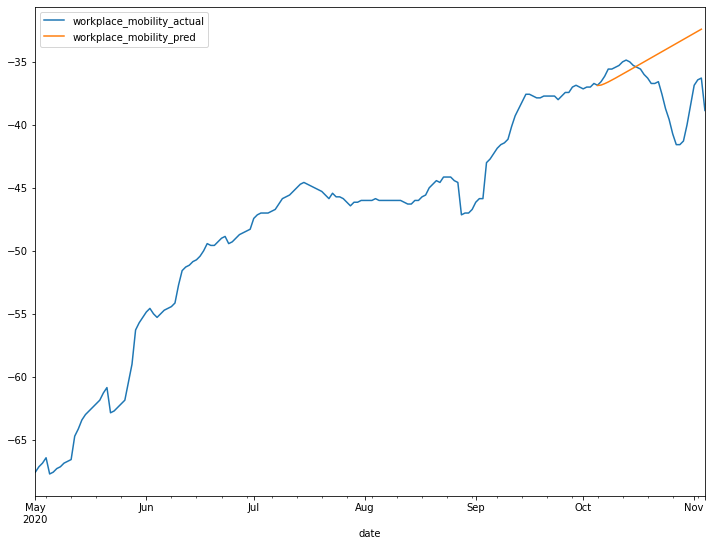

In [52]:
london_forecast = london_forecast[['workplaces_av_undiff','workplaces_av_pred_undiff']]
london_forecast.rename(columns = {'workplaces_av_undiff':'workplace_mobility_actual','workplaces_av_pred_undiff':'workplace_mobility_pred'}, inplace = True)
london_forecast.plot()

# True data in blue
# Forecast in orange

In [53]:
# Metrics:
#https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

true_mob = london_forecast['workplace_mobility_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)] # -1 days required as final element is NaN
pred_mob = london_forecast['workplace_mobility_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_mob = metrics.mean_absolute_error(true_mob, pred_mob)
MSE_mob = metrics.mean_squared_error(true_mob, pred_mob)
MAPE_mob = metrics.mean_absolute_percentage_error(true_mob, pred_mob)

print(f"MAE: {np.round(MAE_mob,3)}")
print(f"MSE: {np.round(MSE_mob,3)}")
print(f"MAPE: {np.round(MAPE_mob,4)*100}%")

MAE: 2.968
MSE: 15.89
MAPE: 7.6499999999999995%


## Prevalence

In [54]:
prev_london = prev[prev['region']=='LONDON']
prev_london = prev_london[['p']]
prev_london.rename(columns = {'p':'p_undiff'},inplace= True)
prev_london=pd.concat([prev_london, data_prev], axis=1)

In [55]:
prev_forecast = prev_london.loc[start_date:forecast_end_date]

In [56]:
# Cumulative sum three times as differenced three times
prev_forecast['undiff1_cum_sum'] = prev_forecast['p_pred'].cumsum()
prev_forecast['undiff2_cum_sum'] = prev_forecast['undiff1_cum_sum'].cumsum()
prev_forecast['undiff3_cum_sum'] = prev_forecast['undiff2_cum_sum'].cumsum()

/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/3313644190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['undiff1_cum_sum'] = prev_forecast['p_pred'].cumsum()
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/3313644190.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['undiff2_cum_sum'] = prev_forecast['undiff1_cum_sum'].cumsum()
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/3313644190.py:4: SettingWithCopyWarning: 
A va

In [57]:
prev_forecast['p_pred_undiff']=np.nan
prev_forecast['p_pred_undiff'].loc[end_date] = prev_forecast['p_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]
prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]

for i in range(1,forecast_steps,1):
    prev_forecast['p_pred_undiff'].loc[end_date+relativedelta(days=i)]=prev_forecast['p_pred_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=i+1)]

    
prev_forecast.tail(31)  

/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/2692868598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['p_pred_undiff']=np.nan
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/2692868598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast['p_pred_undiff'].loc[end_date] = prev_forecast['p_undiff'].loc[end_date]+prev_forecast['undiff3_cum_sum'].loc[end_date+relativedelta(days=1)]
/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/2692868598.py:6: SettingWithCopyWarning: 
A value is t

,p_undiff,p,p_pred,undiff1_cum_sum,undiff2_cum_sum,undiff3_cum_sum,p_pred_undiff
2020-10-05,-5.201207,0.000008,NaN,NaN,NaN,NaN,-5.200929
2020-10-06,-5.186708,NaN,0.000277,0.000277,0.000277,0.000277,-5.200052
2020-10-07,-5.168119,NaN,0.000046,0.000323,0.000600,0.000878,-5.199044
2020-10-08,-5.146090,NaN,0.000085,0.000408,0.001008,0.001886,-5.197592
2020-10-09,-5.119855,NaN,0.000036,0.000444,0.001452,0.003337,-5.195656
2020-10-10,-5.089902,NaN,0.000041,0.000485,0.001936,0.005274,-5.193204
2020-10-11,-5.056828,NaN,0.000031,0.000515,0.002452,0.007725,-5.190206
2020-10-12,-5.021691,NaN,0.000031,0.000546,0.002998,0.010723,-5.186633
2020-10-13,-4.983789,NaN,0.000029,0.000575,0.003573,0.014296,-5.182457
2020-10-14,-4.944657,NaN,0.000028,0.000603,0.004176,0.018472,-5.177650


/var/folders/wr/nfxq8k4j6l59wsc2n57_n_bw0000gn/T/ipykernel_50357/3731272891.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prev_forecast.rename(columns = {'p_undiff':'prevalence_actual','p_pred_undiff':'prevalence_pred'}, inplace = True)


<AxesSubplot:>

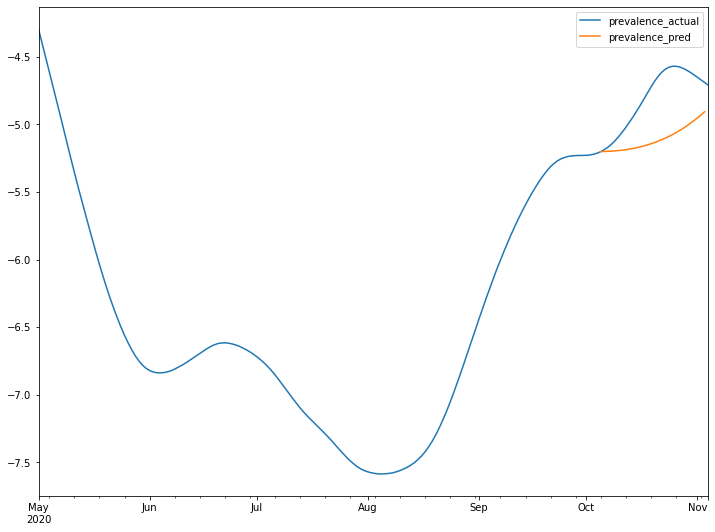

In [58]:
prev_forecast = prev_forecast[['p_undiff','p_pred_undiff']]
prev_forecast.rename(columns = {'p_undiff':'prevalence_actual','p_pred_undiff':'prevalence_pred'}, inplace = True)
prev_forecast.plot()

In [59]:
# Metrics

true_prev = prev_forecast['prevalence_actual'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]
pred_prev = prev_forecast['prevalence_pred'].loc[forecast_start_date:forecast_end_date+relativedelta(days=-1)]

MAE_prev = metrics.mean_absolute_error(true_prev, pred_prev)
MSE_prev = metrics.mean_squared_error(true_prev, pred_prev)
MAPE_prev = metrics.mean_absolute_percentage_error(true_prev, pred_prev)

print(f"MAE: {np.round(MAE_prev,3)}")
print(f"MSE: {np.round(MSE_prev,3)}")
print(f"MAPE: {np.round(MAPE_prev,4)*100}%")

MAE: 0.31
MSE: 0.121
MAPE: 6.61%


In [60]:
# Saving all useful stats from the run

stats =[shift_lag,forecast_steps,log_prevalence,ADF_mob_t,ADF_mob_p,ADF_prev_t,ADF_prev_p,KPSS_mob_stat,KPSS_mob_p,KPSS_prev_stat,KPSS_prev_p,lag_order,lag_order_MSE,
        lag_order_MAPE,resid_corr_mob,resid_corr_prev,johansen_eigenvalue_mob,johansen_trace_mob,johansen_eigenvalue_prev,johansen_trace_prev,johansen_eignvalue_95_mob,
        johansen_eignvalue_95_prev,johansen_trace_95_mob,johansen_trace_95_prev,granger_p_mob_prev_variable,granger_p_prev_mob_variable,granger_p_mob_prev_fixed,granger_p_prev_mob_fixed, granger_lag,MAE_mob,MSE_mob,MAPE_mob,MAE_prev,MSE_prev,MAPE_prev]



stats_colnames = ['shift_lag','forecast_steps','log_prevalence','ADF_mob_t','ADF_mob_p','ADF_prev_t','ADF_prev_p','KPSS_mob_stat','KPSS_mob_p','KPSS_prev_stat','KPSS_prev_p','lag_order','lag_order_MSE','lag_order_MAPE','resid_corr_mob','resid_corr_prev','johansen_eigenvalue_mob','johansen_trace_mob','johansen_eigenvalue_prev','johansen_trace_prev','johansen_eignvalue_95_mob','johansen_eignvalue_95_prev','johansen_trace_95_mob','johansen_trace_95_prev','granger_p_mob_prev_variable','granger_p_prev_mob_variable','granger_p_mob_prev_fixed','granger_p_prev_mob_fixed','granger_lag','MAE_mob','MSE_mob','MAPE_mob','MAE_prev','MSE_prev','MAPE_prev']

In [61]:
stats = pd.DataFrame (stats, stats_colnames)
stats

,0
shift_lag,-14
forecast_steps,30
log_prevalence,True
ADF_mob_t,-3.992209
ADF_mob_p,0.001452
ADF_prev_t,-4.871892
ADF_prev_p,0.00004
KPSS_mob_stat,0.249276
KPSS_mob_p,0.1
KPSS_prev_stat,0.069329
